# Generating stability plots and frequency spectra heatmaps for the macroscopic model

In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

# spectrome modules

from spectrome.utils import functions, path
from spectrome.brain import Brain
from spectrome.forward import ntf_macro_inverselaplace
from spectrome.stability import frequencysweep
from spectrome.forward import runforward_onlymacro

#generic modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
import copy
import seaborn as sns


new_brain = Brain.Brain()

hcp_dir = path.get_data_path() # connectome information is in /data/ dir
new_brain.add_connectome(hcp_dir)   # Use default files in /data/

new_brain.reorder_connectome(new_brain.connectome, new_brain.distance_matrix)
new_brain.bi_symmetric_c()
new_brain.reduce_extreme_dir()

print(new_brain.ntf_params)

{'tau_e': 0.012, 'tau_i': 0.003, 'alpha': 1.0, 'speed': 5.0, 'gei': 4.0, 'gii': 1.0, 'tauC': 0.006}


## Generating macroscopic model roots

In [2]:
# Initial guesses for w and tauC for different values of alpha 
allx0 = [[90,0.005],[90,0.005],[90,0.005],[90,0.0055],[90,0.0055],[90,0.006],
         [90,0.006],[100,0.006],[100,0.006],[100,0.006],[100,0.006],
         [100,0.006],[100,0.006]]


def optim(brain,brain_params,s):

    opt_res = root(
    frequencysweep.network_transfer,
    allx0[s],
    args = (brain,brain_params),
    method = 'hybr',
    options = {'xtol': 1e-12, 'maxfev': 10000}
    )
    return opt_res

ntry = 1

arr = np.zeros((ntry,2))
arr2 = np.zeros((13,3))

alphalist = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 
             0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(alphalist)):
    new_brain.ntf_params['alpha'] = alphalist[i]
        
    for j in range(ntry):
        res = optim(new_brain,new_brain.ntf_params,i)
        arr[j,:] = [res["x"][0],res["x"][1]]

    arg = np.argmin(arr[:,1])

    arr2[i,0] = arr[arg][0]
    arr2[i,1] = arr[arg][1]
    arr2[i,2] = alphalist[i]

print(arr2)

[[8.40306351e+01 5.82874097e-03 2.00000000e-02]
 [8.51347761e+01 5.57459535e-03 5.00000000e-02]
 [8.41109295e+01 5.67026354e-03 1.00000000e-01]
 [8.25329015e+01 6.29551270e-03 1.50000000e-01]
 [8.21225513e+01 6.43134443e-03 2.00000000e-01]
 [8.17203413e+01 6.71479213e-03 3.00000000e-01]
 [8.12482169e+01 6.95377934e-03 4.00000000e-01]
 [8.09573844e+01 7.10074675e-03 5.00000000e-01]
 [8.05605106e+01 7.32130694e-03 6.00000000e-01]
 [7.96443580e+01 7.51363451e-03 7.00000000e-01]
 [7.92238093e+01 7.73063817e-03 8.00000000e-01]
 [7.94272696e+01 7.79339258e-03 9.00000000e-01]
 [7.89968146e+01 7.98227823e-03 1.00000000e+00]]


## Stability plot for macroscopic model

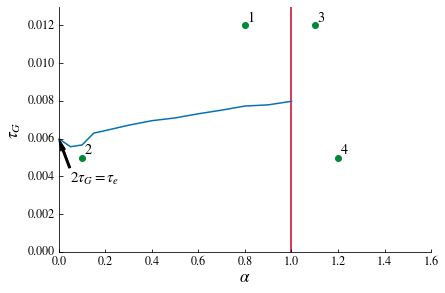

In [3]:
from mpl_toolkits.axisartist.axislines import Subplot

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize":17
})


colors = {0: '#0571b0', #blue
1: '#ca0020' #red
}

markers = {0: 'o',
1: '*'
}

fig = plt.figure()
ax = Subplot(fig, 111)
fig.add_subplot(ax)
   
ax.axis["right"].set_visible(False)
ax.axis["top"].set_visible(False)

arrplot = np.append([[0,0.006,0.0]],arr2, axis=0)

ax.plot(arrplot[:,2],arrplot[:,1],color=colors[0])
ax.set_xlim((0,1.6))
ax.set_ylim((0.0,0.013))
ax.vlines(1.0,0.0,0.013,colors='#ca0020')

label_x = 0.05
label_y = 0.0035
arrow_x = 0
arrow_y = 0.00599

arrow_properties = dict(
    facecolor="black", width=2,
    headwidth=5, shrink=0)

ax.annotate(
    r'$2\tau_G=\tau_e$', xy=(arrow_x, arrow_y),
    xytext=(label_x, label_y),
    arrowprops=arrow_properties,
    verticalalignment='bottom',
    fontsize=15)

ax.set_xlabel(r'$\alpha$',fontsize=17)
ax.set_ylabel(r'$\tau_G$',fontsize=17)

# Plot the points for which I will show the simulations
y = [0.012, 0.005, 0.012, 0.005]
z = [0.8, 0.1, 1.1, 1.2]
n = [1, 2, 3, 4]

ax.scatter(z, y, color = "#008837")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i]+0.01, y[i]+0.0002),fontsize = 14)

plt.tight_layout()


## Generating frequency peak plot

In [ ]:
par_default = {'tau_e': 0.012, 'tau_i': 0.003, 'alpha': 1.0, 'speed': 5.0, 'gei': 1.0, 'gii': 1.0, 'tauC': 0.006}

alphal = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tauCl = np.linspace(0.005,0.012,50)

fmin = 1
fmax = 40
fvec = np.linspace(fmin,fmax,40)
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)

freqpeak = np.zeros((len(alphal),len(tauCl)))

for i in range(len(alphal)):
    for j in range(len(tauCl)):
        new_brain.ntf_params = copy.deepcopy(par_default)
        new_brain.ntf_params['alpha'] = alphal[i]
        new_brain.ntf_params['tauC'] = tauCl[j]
        model_spectrum, _, _, _ = runforward_onlymacro.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)
        filfinal = 0
        for g in range(len(model_spectrum)):
            spectrum = np.abs(model_spectrum[g,:])
            filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
            filfinal += filtered

        filfinal = filfinal/len(model_spectrum)
        maxinbtwn = np.argmax(filfinal[2:])
        fvecm = fvec[2:]
        freqpeak[i,j] = fvecm[maxinbtwn]
        ind = np.where(arr2[:,2]==alphal[i])[0][0]
        if tauCl[j]<arr2[ind,1]:
            freqpeak[i,j] = np.nan


In [ ]:
freqpeakt = np.transpose(freqpeak)

ax = sns.heatmap(freqpeakt,cmap="crest",mask=np.isnan(freqpeakt))
plt.yticks(np.linspace(0,49,6),np.round(np.linspace(0.005,0.012,6),decimals=3))
plt.xticks(np.linspace(0,8,9),np.round(np.linspace(0.1,0.9,9),decimals=1))
plt.ylabel(r'$\tau_G$ (s)',fontsize=17)
plt.xlabel(r'$\alpha$',fontsize=17)
ax.axes.invert_yaxis()

plt.tight_layout()

## Generating frequency spectra heatmaps

In [ ]:
par_default = {'tau_e': 0.012, 'tau_i': 0.003, 'alpha': 0.5, 'speed': 5.0, 'gei': 1.0, 'gii': 1.0, 'tauC': 0.008}
print(par_default)

taue = np.linspace(0.005,2*7.1e-03,50)
tauG = np.linspace(7.10074675e-03,0.04,50)
al = np.linspace(0.1,0.99,50)
sp = np.linspace(1,10,50)

freqres = np.zeros((40,50))

fig, ax = plt.subplots(2, 2,figsize=(8, 6))
cbar_ax = fig.add_axes([.9, .3, .01, .4])

for i in range(50):
    new_brain.ntf_params = copy.deepcopy(par_default)
    new_brain.ntf_params['tau_e'] = taue[i]
    model_spectrum, _, _, _ = runforward_onlymacro.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)
    freqres[:,i] = filfinal

print(new_brain.ntf_params)

sns.heatmap(freqres,cmap="mako",vmax=-50,vmin=-100,ax=ax[0,0],cbar_ax=cbar_ax)
ax[0][0].set_yticks(np.round(np.linspace(0,39,5)))
ax[0][0].set_yticklabels(np.int_(np.linspace(1,40,5)))
ax[0][0].set_xticks(np.linspace(0,49,6))
ax[0][0].set_xticklabels(np.round(np.linspace(0.005,2*7.1e-03,6),decimals=3))
ax[0][0].set_xlabel(r'$\tau_e$ (s)',fontsize=17)
ax[0][0].invert_yaxis()

for i in range(50):
    new_brain.ntf_params = copy.deepcopy(par_default)
    new_brain.ntf_params['tauC'] = tauG[i]
    model_spectrum, _, _, _ = runforward_onlymacro.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)
    freqres[:,i] = filfinal

print(new_brain.ntf_params)
sns.heatmap(freqres,vmax=-50,vmin=-100,cmap="mako",ax=ax[0,1],cbar=0,cbar_ax=None)
ax[0][1].set_yticks(np.round(np.linspace(0,39,5)))
ax[0][1].set_yticklabels(np.int_(np.linspace(1,40,5)))
ax[0][1].set_xticks(np.linspace(0,49,6))
ax[0][1].set_xticklabels(np.round(np.linspace(7.10074675e-03,0.04,6),decimals=3))
ax[0][1].set_xlabel(r'$\tau_G$ (s)',fontsize=17)
ax[0][1].invert_yaxis()

for i in range(50):
    new_brain.ntf_params = copy.deepcopy(par_default)
    new_brain.ntf_params['alpha'] = al[i]
    model_spectrum, _, _, _ = runforward_onlymacro.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)
    freqres[:,i] = filfinal

print(new_brain.ntf_params)
sns.heatmap(freqres,vmax=-50,vmin=-100,cmap="mako",ax=ax[1,0],cbar=0,cbar_ax=None)
ax[1][0].set_yticks(np.round(np.linspace(0,39,5)))
ax[1][0].set_yticklabels(np.int_(np.linspace(1,40,5)))
ax[1][0].set_xticks(np.linspace(0,49,6))
ax[1][0].set_xticklabels(np.round(np.linspace(0.1,0.99,6),decimals=2))
ax[1][0].set_xlabel(r'$\alpha$',fontsize=17)
ax[1][0].invert_yaxis()

for i in range(50):
    new_brain.ntf_params = copy.deepcopy(par_default)
    new_brain.ntf_params['speed'] = sp[i]
    model_spectrum, _, _, _, = runforward_onlymacro.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)
    freqres[:,i] = filfinal

print(new_brain.ntf_params)
sns.heatmap(freqres,vmax=-50,vmin=-100,cmap="mako",ax=ax[1,1],cbar=0,cbar_ax=None)
ax[1][1].set_yticks(np.round(np.linspace(0,39,5)))
ax[1][1].set_yticklabels(np.int_(np.linspace(1,40,5)))
ax[1][1].set_xticks(np.linspace(0,49,6))
ax[1][1].set_xticklabels(np.round(np.linspace(1,10,6),decimals=1))
ax[1][1].set_xlabel(r'$v$ (m/s)',fontsize=17)
ax[1][1].invert_yaxis()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel('Frequency (Hz)',labelpad=12,fontsize=17)

fig.tight_layout(rect=[0, 0, .9, 1])